# SRLUI and Study Outcomes

## Preparations

In [515]:
import pandas as pd
import numpy as np

import math
from scipy.stats import kendalltau
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from datetime import datetime,timedelta

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

## 1. Overview of SRLUI Data
- Target variables (study outcome(
    - Continuous
        - `Grade`
        - `survival_days`
    - Categorical
        - binomial: `drop_out`
- Independent variables
    - Continuous
    - Categorical
        - binomial: `treatment`, `gender`, `useSRLUI`
        - multi-level: `country`
    - Ordinal: `age`, `education`, `userType`

In [516]:
data = pd.read_csv('SRLUImaster_v2.csv',index_col=0)
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 1 to 772
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   userId           768 non-null    int64  
 1   courseId         768 non-null    object 
 2   Grade            768 non-null    int64  
 3   leave_week       768 non-null    int64  
 4   enrollment_week  768 non-null    int64  
 5   survival_days    768 non-null    int64  
 6   drop_out         768 non-null    int64  
 7   treatment        768 non-null    object 
 8   gender           464 non-null    object 
 9   age              497 non-null    float64
 10  education        461 non-null    object 
 11  country          727 non-null    object 
 12  useSRLUI         768 non-null    int64  
 13  userType         312 non-null    object 
dtypes: float64(1), int64(7), object(6)
memory usage: 90.0+ KB
None


,userId,courseId,Grade,leave_week,enrollment_week,survival_days,drop_out,treatment,gender,age,education,country,useSRLUI,userType
1,53576,BAMM101,75,13,1,90,0,control,m,27.0,undergrad,MX,0,NaN
2,503793,BAMM101,26,12,1,78,1,experiment,m,36.0,undergrad,MX,1,heavy
3,1392778,BAMM101,87,13,1,85,0,control,m,26.0,high_sch or under,0,0,NaN
4,1720976,BAMM101,75,14,1,89,0,control,m,NaN,post_grad,0,0,NaN
5,1910178,BAMM101,66,14,1,94,0,control,m,41.0,post_grad,NG,0,NaN


## 2. Correlation Analysis
- 2 steps of correlation analysis
    1. Test whether there is significant correlation relationship
    2. Quantify correlation


#### How to do Correlation analysis of different types of variables
- Summary
    1. **Test**  <html><a href='https://datascience.stackexchange.com/questions/893/how-to-get-correlation-between-two-categorical-variable-and-a-categorical-variab'>reference</a></html>
        - Continuous (Continuous with categorical/ordinal)
            - 2 groups: t-test
            - More groups: ANOVA
        - Categorical - Chi-square with contingency table
    2. **Quantify Correlation**
        - Medium - a useful <html><a href='https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365'>summary</a></html>
            - More methods provided in this article
        - Research gate - a <html><a href='https://www.researchgate.net/post/Can_I_use_Pearsons_correlation_coefficient_to_know_the_relation_between_perception_and_gender_age_income'>link</a></html>
            - Linear/normal/homoscedasticity - Pearson r
            - Not normal - Pearson rho
            - Ordinal - Spearman or Kendall rank correlation
            - Continuous and categorical - eta-squared, or eta
        - Categorical correlation - <html><a href='https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9'>link</a></html>
            - Cramer's V - symmetric
            - Theil's U - not symmetric


### 2.1 Correlation with `Grade`
This is correlation analysis of categorical and continuous variables

#### (1) Test of correlation

<html>
    <p>
     I use one-way ANOVA <a href='https://www.pythonfordatascience.org/anova-python/'>here</a>.
    </p>    
</html>

- ANOVA is mainly used to determine if data from various groups have a common means or not
- Pre-requirement: homogeneity, normality


In [517]:
Features = ['courseId','treatment', 'useSRLUI', 'gender', 'country', 'age', 'education', 'userType']

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

for f in Features:
    model = ols(f'Grade ~ C({f})', data, missing='drop').fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    if aov_table.iloc[0,-1]<0.1:   # when p-value < 0.1, there exists significant correlation relationship
        print('\n',f)
        print(aov_table)


 courseId
                    sum_sq     df         F    PR(>F)
C(courseId)   46523.688025    7.0  5.161789  0.000009
Residual     978564.435673  760.0       NaN       NaN

 useSRLUI
                   sum_sq     df         F    PR(>F)
C(useSRLUI)  4.247964e+03    1.0  3.187512  0.074598
Residual     1.020840e+06  766.0       NaN       NaN

 country
                   sum_sq     df         F    PR(>F)
C(country)  167698.777125   73.0  1.879604  0.000035
Residual    798093.541994  653.0       NaN       NaN

 userType
                    sum_sq     df         F    PR(>F)
C(userType)   12114.007701    1.0  9.516757  0.002219
Residual     394603.171786  310.0       NaN       NaN


In [518]:
x = data[data['useSRLUI']==0]['Grade']
y = data[data['useSRLUI']==1]['Grade']
ttest_ind(x,y)

# useSRLUI is binomial, this is a mean comparison between 2 groups which can be realized by t-test: same result

Ttest_indResult(statistic=-1.7853605019762158, pvalue=0.07459842187535716)

#### (2) Quantify correlation

- `courseId`, `useSRLUI`, `country`: categorical
     - Use eta-squared to compute correlation <html><a href="https://www.statisticshowto.com/eta-squared/">link</a></html>  <html><a href="https://www.theanalysisfactor.com/effect-size/">link</a></html>
- `userType`: ordinal
    - Use Spearman/Kendall Rank Correlation for `userType` <html><a href="https://medium.com/analytics-vidhya/kendall-rank-correlation-python-19524cb0e9a0">link</a>,</html>  <html><a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html">kendalltau</a></html> 
    - Need to drop NA and convert to numerical ordinal values, like 0,1,2,3,...
    
Small correlation coefficients don't mean there is not big correlation. (i.e. Pearson Corr meansures linear correlation but there might be more complex correlation relationship.)

Sometimes, in practice, the significance (p-value) is more meaningful than the absolute value of correlation coefficient as it might be influenced by the sample size, etc.

In [5]:
G_userType = data[['Grade','userType']]
G_userType = G_userType.dropna()          # drop missing values, if users don't use SRLUI, there is a NA
G_userType['userType'] = G_userType['userType'].map({'light': 0, 'heavy': 1})      # convert to numerical values

print('Kendall Tau')
print(kendalltau(G_userType['userType'],G_userType['Grade']))

print('\nSpearman Rank correlation:')
G_userType.corr('spearman')

Kendall Tau
KendalltauResult(correlation=0.14866094311488548, pvalue=0.0014938657753926384)

Spearman Rank correlation:


,Grade,userType
Grade,1.000000,0.180087
userType,0.180087,1.000000


In [6]:
model = ols(f'Grade ~ C(courseId)', data).fit()
anova_table(sm.stats.anova_lm(model, typ=2))

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(courseId),46523.688025,7.0,6646.241146,5.161789,0.000009,0.045385,0.036547
Residual,978564.435673,760.0,1287.584784,NaN,NaN,NaN,NaN


In [7]:
model = ols(f'Grade ~ C(useSRLUI)', data).fit()
anova_table(sm.stats.anova_lm(model, typ=2))

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(useSRLUI),4.247964e+03,1.0,4247.963948,3.187512,0.074598,0.004144,0.00284
Residual,1.020840e+06,766.0,1332.689504,NaN,NaN,NaN,NaN


In [8]:
model = ols(f'Grade ~ C(country)', data).fit()
anova_table(sm.stats.anova_lm(model, typ=2))

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(country),167698.777125,73.0,2297.243522,1.879604,0.000035,0.173639,0.081155
Residual,798093.541994,653.0,1222.195317,NaN,NaN,NaN,NaN


### 2.2 Correlation with `survival_days`
This is correlation analysis of categorical and continuous variables

#### (1) Test of correlation

<html>
    <p>
     I use one-way ANOVA <a href='https://www.pythonfordatascience.org/anova-python/'>here</a>.
    </p>    
</html>

In [9]:
for f in Features:
    model = ols(f'survival_days ~ C({f})', data, missing='drop').fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    if aov_table.iloc[0,-1]<0.1:   # when p-value < 0.1, there exists significant correlation relationship
        print('\n',f)
        print(aov_table)


 country
                   sum_sq     df         F    PR(>F)
C(country)   69870.959392   73.0  1.374989  0.025714
Residual    454556.484900  653.0       NaN       NaN

 userType
                    sum_sq     df          F        PR(>F)
C(userType)   14916.937729    1.0  26.601095  4.469264e-07
Residual     173836.857143  310.0        NaN           NaN


#### (2) Quantify correlation

- `country`: categorical
     - Use eta-squared to compute correlation <html><a href="https://www.statisticshowto.com/eta-squared/">link</a></html>  <html><a href="https://www.theanalysisfactor.com/effect-size/">link</a></html>
- `userType`: ordinal
    - Use Spearman/Kendall Rank Correlation for `userType` <html><a href="https://medium.com/analytics-vidhya/kendall-rank-correlation-python-19524cb0e9a0">link</a>,</html>  <html><a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html">kendalltau</a></html> 
    - Need to drop NA and convert to numerical ordinal values, like 0,1,2,3,...

In [10]:
model = ols(f'survival_days ~ C(useSRLUI)', data).fit()
anova_table(sm.stats.anova_lm(model, typ=2))

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(useSRLUI),1862.002551,1.0,1862.002551,2.565128,0.109656,0.003338,0.002034
Residual,556032.242240,766.0,725.890656,NaN,NaN,NaN,NaN


In [11]:
model = ols(f'survival_days ~ C(country)', data).fit()
anova_table(sm.stats.anova_lm(model, typ=2))

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(country),69870.959392,73.0,957.136430,1.374989,0.025714,0.133233,0.036287
Residual,454556.484900,653.0,696.104877,NaN,NaN,NaN,NaN


### 2.2 Correlation with `survival_days`
This is correlation analysis of categorical and continuous variables

#### (1) Test of correlation

In [12]:
for f in Features:
    model = ols(f'drop_out ~ C({f})', data).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    if aov_table.iloc[0,-1]<0.1:   # when p-value < 0.1, there exists significant correlation relationship
        print('\n',f)
        print(aov_table)


 courseId
                 sum_sq     df          F        PR(>F)
C(courseId)   17.347612    7.0  11.230187  1.401135e-13
Residual     167.713586  760.0        NaN           NaN

 country
                sum_sq     df         F    PR(>F)
C(country)   23.689689   73.0  1.408728  0.017898
Residual    150.425855  653.0       NaN       NaN

 userType
                sum_sq     df          F    PR(>F)
C(userType)   2.780229    1.0  11.947259  0.000624
Residual     72.139643  310.0        NaN       NaN


In [13]:
data.groupby(['treatment']).mean()[['Grade','survival_days','drop_out']]

,Grade,survival_days,drop_out
treatment,,,
control,48.412256,66.601671,0.378830
experiment,47.523227,63.863081,0.427873


In [14]:
data.groupby(['treatment','useSRLUI']).median()[['Grade','survival_days','drop_out']]

Grade  survival_days  drop_out
treatment  useSRLUI                                
control    0            63             76         0
experiment 0            19             57         1
           1            66             73         0

In [15]:
data.groupby(['treatment','useSRLUI']).mean()[['Grade','survival_days','drop_out']]

Grade  survival_days  drop_out
treatment  useSRLUI                                    
control    0         48.412256      66.601671  0.378830
experiment 0         37.041237      53.690722  0.515464
           1         50.782051      67.025641  0.400641

In [16]:
data.groupby(['useSRLUI','userType']).mean()[['Grade','survival_days','drop_out']]

Grade  survival_days  drop_out
useSRLUI userType                                    
1        heavy     55.445000      72.200000  0.330000
         light     42.455357      57.785714  0.526786

##### Control group
`treatment` = control

(array([100.,  22.,  17.,  15.,   6.,   9.,  28.,  55.,  58.,  49.]),
 array([ 0. ,  9.8, 19.6, 29.4, 39.2, 49. , 58.8, 68.6, 78.4, 88.2, 98. ]),
 <a list of 10 Patch objects>)

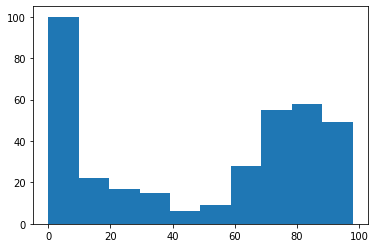

In [17]:
y = data[data['treatment'] == 'control']['Grade'].values
plt.hist(y)

##### Experiment group
##### `useSRLUI` = 0

(array([46.,  3.,  1.,  2.,  1.,  6.,  7.,  9., 17.,  5.]),
 array([ 0. ,  9.8, 19.6, 29.4, 39.2, 49. , 58.8, 68.6, 78.4, 88.2, 98. ]),
 <a list of 10 Patch objects>)

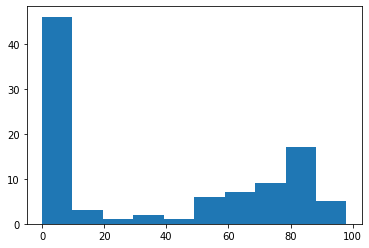

In [18]:
y = data[data['treatment'] == 'experiment'][data['useSRLUI'] == 0]['Grade'].values
plt.hist(y)

##### Experiment group
##### `useSRLUI` = 1

(array([76., 24., 24.,  5.,  8.,  7., 23., 39., 64., 42.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

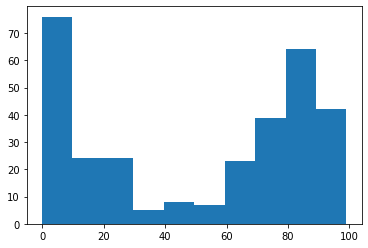

In [19]:
y = data[data['treatment'] == 'experiment'][data['useSRLUI'] == 1]['Grade'].values
plt.hist(y)

##### Experiment group
##### `useSRLUI` = 1 and `userType` = light

(array([37.,  9., 11.,  1.,  1.,  5.,  6., 13., 19., 10.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

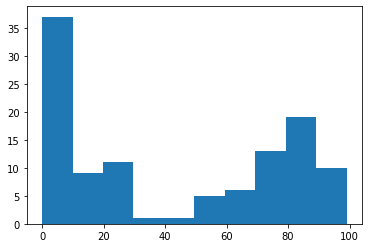

In [20]:
y = data[data['treatment'] == 'experiment'][data['useSRLUI'] == 1][data['userType'] == 'light']['Grade'].values
plt.hist(y)

##### Experiment group
##### `useSRLUI` = 1 and `userType` = heavy

(array([39., 15., 13.,  4.,  4.,  4., 14., 26., 41., 40.]),
 array([ 0. ,  9.8, 19.6, 29.4, 39.2, 49. , 58.8, 68.6, 78.4, 88.2, 98. ]),
 <a list of 10 Patch objects>)

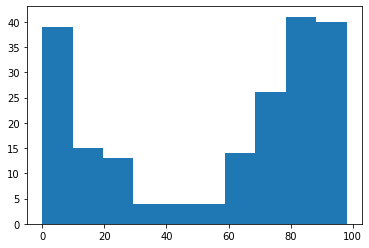

In [21]:
y = data[data['treatment'] == 'experiment'][data['useSRLUI'] == 1][data['userType'] == 'heavy']['Grade'].values
plt.hist(y)

## 3. Correlation Matrix

In this part, I will create a correlation matrix to show the correlation coefficients between all pairs of variabls including independent an dependent variables. And I will use `Kendall Tau` here as the measurement. <html><a href="https://medium.com/analytics-vidhya/kendall-rank-correlation-python-19524cb0e9a0">link</a>,</html>  <html><a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html">kendalltau</a></html> 

For observations ($x_i$, $y_i$), ($x_j$, $y_j$):
- Cordant pairs: if $x_i$ < $x_j$ and $y_i$ < $y_j$, or $x_i$ > $x_j$ and $y_i$ > $y_j$
- Discordant pairs: if $x_i$ < $x_j$ and $y_i$ > $y_j$, or $x_i$ > $x_j$ and $y_i$ < $y_j$
- Ties: $x_i$ = $x_j$ or $y_i$ = $y_j$
- $T$: the number of ties only in $x$ 
- $U$: the number of ties only in $y$


    - Kendall $\tau_a$
$$\tau_a = \frac{(number of cordant pairs)-(number of discordant pairs)}{n \choose 2} = \frac{n_c - n_d}{n_0}$$
    - Kendall $\tau_b$
$$\tau_b = \frac{n_c - n_d}{\sqrt{(n_c + n_d + T) * (n_c + n_d + U)}}$$


### 3.1 Convert continuous into categorical
I will use `Kendall Tau` here as the measurement. Therefore, I will convert `Grade` and `survival_days` into categorical variablses.

1. `Grades`: using 10 points as a unit, total range is 1-100: 1-10,11-20
2. `survival_days`: weeks, 70 days means 7 weeks

In [22]:
data.head()

,userId,courseId,Grade,leave_week,enrollment_week,survival_days,drop_out,treatment,gender,age,education,country,useSRLUI,userType
1,53576,BAMM101,75,13,1,90,0,control,m,27.0,undergrad,MX,0,NaN
2,503793,BAMM101,26,12,1,78,1,experiment,m,36.0,undergrad,MX,1,heavy
3,1392778,BAMM101,87,13,1,85,0,control,m,26.0,high_sch or under,0,0,NaN
4,1720976,BAMM101,75,14,1,89,0,control,m,NaN,post_grad,0,0,NaN
5,1910178,BAMM101,66,14,1,94,0,control,m,41.0,post_grad,NG,0,NaN


In [23]:
data['C_grade'] = data['Grade']/10
data['C_survival'] = data['survival_days']/7
data['C_grade'] = data['C_grade'].apply(math.ceil)
data['C_survival'] = data['C_survival'].apply(math.ceil)

In [24]:
data.head()

,userId,courseId,Grade,leave_week,enrollment_week,survival_days,drop_out,treatment,gender,age,education,country,useSRLUI,userType,C_grade,C_survival
1,53576,BAMM101,75,13,1,90,0,control,m,27.0,undergrad,MX,0,NaN,8,13
2,503793,BAMM101,26,12,1,78,1,experiment,m,36.0,undergrad,MX,1,heavy,3,12
3,1392778,BAMM101,87,13,1,85,0,control,m,26.0,high_sch or under,0,0,NaN,9,13
4,1720976,BAMM101,75,14,1,89,0,control,m,NaN,post_grad,0,0,NaN,8,13
5,1910178,BAMM101,66,14,1,94,0,control,m,41.0,post_grad,NG,0,NaN,7,14


In [25]:
data['treatment'].value_counts()

experiment    409
control       359
Name: treatment, dtype: int64

In [26]:
vars_df = data[['C_grade','C_survival','userType','useSRLUI',
                'education','age','gender','treatment']]

# UserType ---> 'heavy users': light=0, heavy=1
def heavy_1(x):
    if x == 'heavy':
        return 1
    elif x == 'light':
        return 0
vars_df['userType'] = vars_df['userType'].apply(heavy_1)

# Education: other=0, high_sch or under=1, undergrad=2, post_grad=3
def edu(x):
    if x == 'other':
        return 0
    elif x == 'high_sch or under':
        return 1
    elif x == 'undergrad':
        return 2
    elif x == 'post_grad':
        return 3
vars_df['education'] = vars_df['education'].apply(edu)

# Gender ---> 'female':: male=0, female=1
vars_df['gender'] = (vars_df['gender']=='f')*1

# Treatment: control=0, Experiment=1
vars_df['treatment'] = (vars_df['treatment']=='experiment')*1

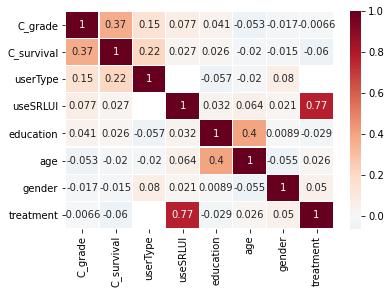

In [27]:
corr_matrix = vars_df.corr('kendall')
sb.heatmap(corr_matrix, 
            xticklabels = corr_matrix.columns,
            yticklabels = corr_matrix.columns,
            cmap = 'RdBu_r',
            center = 0,
            annot = True,
            linewidth = 0.2)



In [28]:
print('Correlation Matrix')

corr_matrix

Correlation Matrix


,C_grade,C_survival,userType,useSRLUI,education,age,gender,treatment
C_grade,1.000000,0.372633,0.153623,0.076829,0.040949,-0.053138,-0.017300,-0.006564
C_survival,0.372633,1.000000,0.219963,0.027401,0.026442,-0.020055,-0.015286,-0.060191
userType,0.153623,0.219963,1.000000,NaN,-0.057356,-0.020028,0.079810,NaN
useSRLUI,0.076829,0.027401,NaN,1.000000,0.031681,0.063603,0.020701,0.774962
education,0.040949,0.026442,-0.057356,0.031681,1.000000,0.403239,0.008941,-0.029145
age,-0.053138,-0.020055,-0.020028,0.063603,0.403239,1.000000,-0.055206,0.026175
gender,-0.017300,-0.015286,0.079810,0.020701,0.008941,-0.055206,1.000000,0.049827
treatment,-0.006564,-0.060191,NaN,0.774962,-0.029145,0.026175,0.049827,1.000000


P-values Matrix of Correlation


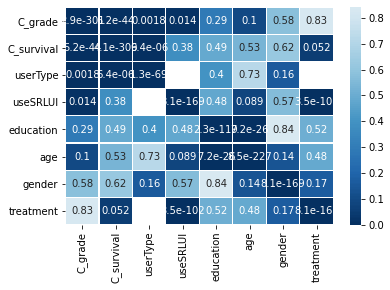

In [29]:
p_value = corr_matrix.copy()


# compute p-calues for all paris of variables
for i in p_value.columns:
    for j in p_value.columns:
        p_value.loc[i,j] = kendalltau(vars_df[i], vars_df[j], nan_policy='omit')[-1]

# heatmap visualization of p-value matrix
sb.heatmap(p_value, 
            xticklabels = p_value.columns,
            yticklabels = p_value.columns,
            cmap = 'RdBu_r',
            center = 1,
            annot = True,
            linewidth = 0.2)   

print('P-values Matrix of Correlation')


## 5. SRLUI v2: Retreiving Demographic Data
Gather all demographic information from raw data.

Education level:
- Use data from data-learner (demographic documents)
- High school or Under: el (elementary), jhs (junior high school), hs (high school)
- Undergraduate: a (associate), b (bachelor)
- Post graduate: m (master), p (professional), p_oth, p_se
- Others: other, none, blank
- Response rate: the percent of all cases that are not blank


Demographic info:
`userId`
`courseId`
`gender`
`age`
`education`
`country`

Other info:
leave_week
enrollment_week # need to know the start date of the course
survival_days
drop_out
treatment
useSRLUI
userType
C_grade
C_survival

In [30]:
BM1 = 'SRLUI_v2_demographic_0705/Demographic_Folder/original_dataset/data-learners_ColumbiaX+BAMM.101x+1T2020.csv'
BM2 = 'SRLUI_v2_demographic_0705/Demographic_Folder/original_dataset/data-learners_ColumbiaX+BAMM.102x+1T2020.csv'
BM3 = 'SRLUI_v2_demographic_0705/Demographic_Folder/original_dataset/data-learners_ColumbiaX+BAMM.103x+1T2020.csv'
BM4 = 'SRLUI_v2_demographic_0705/Demographic_Folder/original_dataset/data-learners_ColumbiaX+BAMM.104x+1T2020.csv'
CS1 = 'SRLUI_v2_demographic_0705/Demographic_Folder/original_dataset/data-learners_ColumbiaX+CSMM.101x+1T2020.csv'
CS2 = 'SRLUI_v2_demographic_0705/Demographic_Folder/original_dataset/data-learners_ColumbiaX+CSMM.102x+1T2020.csv'
CS3 = 'SRLUI_v2_demographic_0705/Demographic_Folder/original_dataset/data-learners_ColumbiaX+CSMM.103x+1T2020.csv'
CS4 = 'SRLUI_v2_demographic_0705/Demographic_Folder/original_dataset/data-learners_ColumbiaX+CSMM.104x+1T2020.csv'

In [31]:
pd.read_csv(CS1)['level_of_education'].value_counts()

b        4192
m        2928
hs       2731
a         487
p         437
jhs       283
other     200
el         46
none       23
p_se       19
p_oth       5
Name: level_of_education, dtype: int64

In [32]:
def edu(x):
        if x=='m':
            return 'post_grad'
        elif x=='p':
            return 'post_grad'
        elif x=='p_oth':
            return 'post_grad'
        elif x=='p_se':
            return 'post_grad'
        
        elif x=='el':
            return 'high_sch or under'
        elif x=='jhs':
            return 'high_sch or under'
        elif x=='hs':
            return 'high_sch or under'
        
        elif x=='a':
            return 'undergrad'
        elif x=='b':
            return 'undergrad'
        
        else:
            return 'other'

In [33]:
def demo_data(file):
    
    data = pd.read_csv(file, index_col = 0)
    data_v = data[data['enrollment_mode']=='verified']
    data_v['year_of_birth'] = pd.to_datetime(data_v['year_of_birth'])
    data_v['now'] = datetime.now()
    data_v['age'] = data_v['now']-data_v['year_of_birth']
    data_v['age'] = round(data_v['age']/np.timedelta64(1, 'Y'))

    data_v['education'] = data_v['level_of_education'].apply(edu)
    data_v = data_v[['user_id','courseId','enrollment_mode','gender','age','education','country']]
    return data_v

In [34]:
BAMM101 = demo_data(BM1)
BAMM102 = demo_data(BM2)
BAMM103 = demo_data(BM3)
BAMM104 = demo_data(BM4)
CSMM101 = demo_data(CS1)
CSMM102 = demo_data(CS2)
CSMM103 = demo_data(CS3)
CSMM104 = demo_data(CS4)

In [35]:
BAMM101.to_csv('BAMM101_DemographicInfo.csv')
BAMM102.to_csv('BAMM102_DemographicInfo.csv')
BAMM103.to_csv('BAMM103_DemographicInfo.csv')
BAMM104.to_csv('BAMM104_DemographicInfo.csv')
CSMM101.to_csv('CSMM101_DemographicInfo.csv')
CSMM102.to_csv('CSMM102_DemographicInfo.csv')
CSMM103.to_csv('CSMM103_DemographicInfo.csv')
CSMM104.to_csv('CSMM104_DemographicInfo.csv')

In [36]:
#CS: India,USA,Pakistan,UK	Canada	Brazil	Germany	Egypt	China	Nigeria
C = ['IN','US','PK','GB','CA','BR','DE','EG','CN','NG']
# BA: India	USA	UK	Canada	China	Brazil	Germany	Spain	Nigeria	Australia
C = ['IN','US','GB','CA','CN','BR','DE','ES','NG','AU']

In [37]:
data = pd.read_csv(BM4)

def c_num(country):
    print(data.shape)
    return (data['country']==country).sum()
c_num(C[0]),c_num(C[1]),c_num(C[2]),c_num(C[3]),c_num(C[4]),c_num(C[5]),c_num(C[6]),c_num(C[7]),c_num(C[8]),c_num(C[9])

(16247, 8)
(16247, 8)
(16247, 8)
(16247, 8)
(16247, 8)
(16247, 8)
(16247, 8)
(16247, 8)
(16247, 8)
(16247, 8)


(4205, 2240, 409, 421, 155, 456, 259, 259, 165, 198)

## 6. SRLUI v2: Retreiving Learner Engagement Data

This is for survival analysis:
- **How many days students are active in the course during the course period.**
- When students come in and when they leave.

`survival_days` (Persistent_days) = MIN{last time logging in, 5/25(end date)} - MAX{first time logging in, 2/9(start date}

`drop_out`
    - 1 if no log in during 5/9-5/25(final)
    - 0 if log in during final weeks(5/9-5/25)
    - CSMM103 is different

`enrollment_week` = the week of enrollment

`leave_week_of_activity` = the week of last activity record

In [38]:
BAMM101_engage = pd.read_csv('SRLUI_v2_engagement_0710/data-engagement_ColumbiaX+BAMM.101x+1T2020.csv')
BAMM102_engage = pd.read_csv('SRLUI_v2_engagement_0710/data-engagement_ColumbiaX+BAMM.102x+1T2020.csv')
BAMM103_engage = pd.read_csv('SRLUI_v2_engagement_0710/data-engagement_ColumbiaX+BAMM.103x+1T2020.csv')
BAMM104_engage = pd.read_csv('SRLUI_v2_engagement_0710/data-engagement_ColumbiaX+BAMM.104x+1T2020.csv')
CSMM101_engage = pd.read_csv('SRLUI_v2_engagement_0710/data-engagement_ColumbiaX+CSMM.101x+1T2020.csv')
CSMM102_engage = pd.read_csv('SRLUI_v2_engagement_0710/data-engagement_ColumbiaX+CSMM.102x+1T2020.csv')
CSMM103_engage = pd.read_csv('SRLUI_v2_engagement_0710/data-engagement_ColumbiaX+CSMM.103x+1T2020.csv')
CSMM104_engage = pd.read_csv('SRLUI_v2_engagement_0710/data-engagement_ColumbiaX+CSMM.104x+1T2020.csv')

### **CS101, 102, 104, BA101-BA104** 

open for 14 weeks

`2/10/2020`-`5/17/2020` (14 weeks for assignments)

`5/9/2020`-`5/25/2020` (14th, 15th for `finals`)

1st week 2/9/2020-2/16/2020

2nd week 2/17/2020- 2/14/2020

In [39]:
course_start1 = pd.to_datetime('2/9/2020')
course_end1 = pd.to_datetime('5/25/2020')
final_start1 = pd.to_datetime('2020-05-09')
final_end1 = pd.to_datetime('2020-05-25')

In [40]:
# Create a function user_engagement() to create the variables needed

def user_engagement(df,course_start,course_end,final_start,final_end): 
   
    # delete all records when there are no activities
    df['activity'] = df['problems_completed'] + df['problems_attempted'] + df['videos_viewed'] + df['discussion_contributions']
    df = df[df['activity']>0]
    
    df['date'] = pd.to_datetime(df['date'])
    df['week'] = df['date'] - course_start
    df['week'] = df['week']/np.timedelta64(1,'W')
    df['week'] = df['week'].apply(math.ceil)
    user = df.groupby('name').agg({
        'date':['min','max'],
        'week':['min','max']    
    }).reset_index()
    user.columns = [''.join(col).strip() for col in user.columns.values]
    
    def turn_negtive_to_0(x):
        return max(x, 0) 
    user['weekmax'] = user['weekmax'].apply(turn_negtive_to_0)
    user['weekmin'] = user['weekmin'].apply(turn_negtive_to_0)
    
    def start(x):
        return max(x, course_start) 
    def end(x):
        return min(x, course_end) 
    user['start_date'] = user['datemin'].apply(start)   # start_date = MAX{first time logging in, 2/9/2020} 
    user['end_date'] = user['datemax'].apply(end)       # end_date = MIN{last time logging in, 5/25/2020}
    user['survival_days'] = (user['end_date'] - user['start_date'])/np.timedelta64(1,'D') + 1
    user['survival_days']  = user['survival_days'].apply(turn_negtive_to_0)
    
    def drop(x):
        if x >= final_start and  x <= final_end:
            return 0
        else:
            return 1                                    # if datemax lies within final week, dropout = 0
    user['drop_out'] = user['datemax'].apply(drop)      # datemax: the lastest date logging in
                                                        
    user['enrollment_week'] = user['weekmin']
    user['leave_week_of_activity'] = user['weekmax']
    
    return user[['name','survival_days','drop_out','enrollment_week','leave_week_of_activity']]

In [41]:
# apply the function user_engagement() to 7 courses whose periods are 2/9/2020 - 5/25/2020
BAMM101_user_engagement = user_engagement(BAMM101_engage,course_start1,course_end1,final_start1,final_end1)
BAMM102_user_engagement = user_engagement(BAMM102_engage,course_start1,course_end1,final_start1,final_end1)
BAMM103_user_engagement = user_engagement(BAMM103_engage,course_start1,course_end1,final_start1,final_end1)
BAMM104_user_engagement = user_engagement(BAMM104_engage,course_start1,course_end1,final_start1,final_end1)
CSMM101_user_engagement = user_engagement(CSMM101_engage,course_start1,course_end1,final_start1,final_end1)
CSMM102_user_engagement = user_engagement(CSMM102_engage,course_start1,course_end1,final_start1,final_end1)
CSMM104_user_engagement = user_engagement(CSMM104_engage,course_start1,course_end1,final_start1,final_end1)

# add courseID column
BAMM101_user_engagement['courseId'] = 'BAMM101'
BAMM102_user_engagement['courseId'] = 'BAMM102'
BAMM103_user_engagement['courseId'] = 'BAMM103'
BAMM104_user_engagement['courseId'] = 'BAMM104'
CSMM101_user_engagement['courseId'] = 'CSMM101'
CSMM102_user_engagement['courseId'] = 'CSMM102'
CSMM104_user_engagement['courseId'] = 'CSMM104'

In [42]:
# output the csv files
BAMM101_user_engagement.to_csv('SRLUI_v2_engagement_0710/output/BAMM101_user_engagement.csv')
BAMM102_user_engagement.to_csv('SRLUI_v2_engagement_0710/output/BAMM102_user_engagement.csv')
BAMM103_user_engagement.to_csv('SRLUI_v2_engagement_0710/output/BAMM103_user_engagement.csv')
BAMM104_user_engagement.to_csv('SRLUI_v2_engagement_0710/output/BAMM104_user_engagement.csv')
CSMM101_user_engagement.to_csv('SRLUI_v2_engagement_0710/output/CSMM101_user_engagement.csv')
CSMM102_user_engagement.to_csv('SRLUI_v2_engagement_0710/output/CSMM102_user_engagement.csv')
CSMM104_user_engagement.to_csv('SRLUI_v2_engagement_0710/output/CSMM104_user_engagement.csv')

### **CS103** 
Open for 12 weeks

- Course start date: `2/9/2020` - `5/11/2020`
- Assignment due on: `5/3/2020`
- Final exam starts from `4/20/2020`-`5/11/2020`

In [43]:
course_start2 = pd.to_datetime('2/9/2020')
course_end2 = pd.to_datetime('5/11/2020')
final_start2 = pd.to_datetime('2020-04-20')
final_end2 = pd.to_datetime('2020-05-11')

In [44]:
# apply the function user_engagement() to CS103 whose period is 2/9/2020 - 5/11/2020
CSMM103_user_engagement = user_engagement(CSMM103_engage,course_start2,course_end2,final_start2,final_end2)
CSMM103_user_engagement.to_csv('SRLUI_v2_engagement_0710/output/CSMM103_user_engagement.csv')
CSMM103_user_engagement['courseId'] = 'CSMM103'

### Combine data of 6 courses

In [45]:
SRLUIv2_user_engagement = pd.concat([BAMM101_user_engagement,
                                     BAMM102_user_engagement,
                                     BAMM103_user_engagement,
                                     BAMM104_user_engagement,
                                     CSMM101_user_engagement,
                                     CSMM102_user_engagement,
                                     CSMM103_user_engagement,
                                     CSMM104_user_engagement]).reset_index().drop(columns='index')

In [46]:
SRLUIv2_user_engagement.to_csv('SRLUI_v2_engagement_0710/output/SRLUIv2_user_engagement')

### Questions needed to be clarified

- `name` = `userId`? No userid here
- If there is only 1 logging in activity (1 record), `survival_days`=1
- If the first record is before 2/9, `enrollment_week` = 0
- If logging in before 2/9/2020, I set the `enrollment_week` = 0
    - That being said, if both `enrollment_week` and `leave_week_of_activity` = 0, logging in only once before 2/9
    - So, in this case, if the only record occurs out of 2/9-5/25, the `survival_days`=0 instead of 1

In [47]:
CSMM104_user_engagement.sort_values(['enrollment_week'])

,name,survival_days,drop_out,enrollment_week,leave_week_of_activity,courseId
613,berkaykurkcu,0.0,1,0,0,CSMM104
1178,vaibhavibhide289,0.0,1,0,0,CSMM104
181,FurkanAliGn,0.0,1,0,0,CSMM104
602,ayeshriz,19.0,1,0,3,CSMM104
937,melisdiary,106.0,0,1,16,CSMM104
...,...,...,...,...,...,...
352,MwemaChitafu,1.0,0,15,15,CSMM104
913,manas161,1.0,0,15,15,CSMM104
382,O-G-Derrick,1.0,0,16,16,CSMM104
196,Habib_et_salwa,1.0,0,16,16,CSMM104


In [48]:
CSMM104_engage[CSMM104_engage['name']=='manas161'] # survival_days = 1

,discussion_contributions,problems_attempted,videos_viewed,problems_completed,date,name,activity
7030,0,0,2,0,2020-05-21,manas161,2


In [49]:
CSMM104_engage[CSMM104_engage['name']=='FurkanAliGn'] # survival_days = 0

,discussion_contributions,problems_attempted,videos_viewed,problems_completed,date,name,activity
1017,0,0,2,0,2020-01-23,FurkanAliGn,2


## 7. Retrevie User Usage/Activity Data

In [519]:
goals     = pd.read_csv('SRLUI_v2_activity_0714/goals.csv')
reminders = pd.read_csv('SRLUI_v2_activity_0714/reminders.csv')
slider    = pd.read_csv('SRLUI_v2_activity_0714/slider.csv')

weekid    = pd.read_csv('SRLUI_v2_activity_0714/weekid.csv')

### 7. 1 Remove Admin users and NAN users

In [520]:
admins = ['jl5239@columbia.edu','farif@edx.org','han2114@columbia.edu','jbryant@edx.org',
          'jiahao.h@columbia.edu','kl3071@columbia.edu','ll3251@tc.columbia.edu',
          'mg3856@columbia.edu','nd2588@columbia.edu','sh3146@columbia.edu',
          'xc2496@tc.columbia.edu','ves2126@columbia.edu','wd2303@columbia.edu',
          'xj2224@columbia.edu',
          'chenxiaowen0620@gmail.com',
          'tz2378@columbia.edu','sh3146@columbia.edu','shaw.vivienne@gmail.com',
          'yomy1996@qq.com','mg3856@columbia.edu','hsu.shuyi@gmail.com',np.nan]

print(goals.shape, reminders.shape, slider.shape)

(2903, 11) (1601, 14) (2143, 7)


In [521]:
def remove_admin(x):
    if x in admins:
        return 1
    else:
        return 0

goals['isadmin'] = goals['email'].apply(remove_admin)
goals = goals[goals['isadmin']==0]
reminders['isadmin'] = reminders['email'].apply(remove_admin)
reminders = reminders[reminders['isadmin']==0]
slider['isadmin'] = slider['email'].apply(remove_admin)
slider = slider[slider['isadmin']==0]

#### 7.1.1 Goals Overview

- `weekNumber`: missing, related to weekId? - what is the week number of the content?
- `weekId`: the related study content, should be converted to 1-12
- `createDate`: the week related to the activity

In [522]:
print(goals.shape)
goals.head(3)

(2861, 12)


,userId,courseId,email,group,weekNumber,weekId,createDate,goal1,goal2,goal3,goal4,isadmin
13,18513183.0,ColumbiaX+CSMM.102x+3T2019,yunchao.lin10@gmail.com,NaN,NaN,72447618dfce491584fb7c45f709e99a,2019-10-02T18:20:33.171Z,1,1,1,1,0
16,24976941.0,ColumbiaX+BAMM.104x+3T2019,danielegiambra@libero.it,NaN,NaN,d30ecf0ccb6143909d5660bfa57473fe,2019-10-02T20:39:58.206Z,NaN,NaN,NaN,NaN,0
17,23105767.0,ColumbiaX+CSMM.102x+3T2019,gecrodriguezpe@unal.edu.co,NaN,NaN,72447618dfce491584fb7c45f709e99a,2019-10-02T21:13:59.749Z,NaN,NaN,NaN,NaN,0


#### 7.1.2 Reminders Overview

- `weekNumber`: related to weekId?
- `weekId`: the related study content, should be converted to 1-12
- `createDate`: missing

In [523]:
print(reminders.shape)
reminders.head(3)

(1542, 15)


,userId,courseId,email,weekNumber,weekId,task1,date1,offset1,task2,date2,offset2,task3,date3,offset3,isadmin
38,18513183,ColumbiaX+CSMM.102x+3T2019,yunchao.lin10@gmail.com,3,72447618dfce491584fb7c45f709e99a,NaN,NaN,10,NaN,NaN,10.0,NaN,NaN,10.0,0
39,18513183,ColumbiaX+CSMM.102x+3T2019,yunchao.lin10@gmail.com,3,72447618dfce491584fb7c45f709e99a,NaN,NaN,10,NaN,NaN,10.0,NaN,NaN,10.0,0
40,1864359,ColumbiaX+CSMM.101x+3T2019,marlon.ortiz@outlook.com,3,72ad68365307491198cfcadeeb17baad,watch week video,1.570395e+12,10,Complete prerequisite knowledge assignment,1.570481e+12,10.0,review linear algebra and probability,1.570568e+12,10.0,0


#### 7.1.3 Slider Overview

- `weekNumber`: missing, should be created using weekId - what is the week number of the content?
- `weekId`: the related study content, should be converted to 1-12
- `createDate`: missing

In [524]:
print(slider.shape)
slider.head(3)

(2109, 8)


,userId,courseId,email,weekNumber,weekId,createDate,sliderPercentage,isadmin
10,25556728,ColumbiaX+BAMM.104x+3T2019,lcspictures165@gmail.com,NaN,d30ecf0ccb6143909d5660bfa57473fe,2019-10-02T17:59:54.549Z,50,0
11,25556728,ColumbiaX+BAMM.104x+3T2019,lcspictures165@gmail.com,NaN,NaN,2019-10-02T18:05:34.304Z,67,0
12,18513183,ColumbiaX+CSMM.102x+3T2019,yunchao.lin10@gmail.com,NaN,NaN,2019-10-02T18:20:21.357Z,50,0


### 7.2 Delete duplicate and empty values

#### 7.2.1 Empty values

Empty values - if all of (goal1, goal2, goal3, goal4) are NaN ==> empty

Empty values - if all of (task1, task2, task3) are NaN ==> empty


In [525]:
print('Before/After deleting empty values, the dataset shape: \ngoals \treminders \tslider')
print(goals.shape, reminders.shape, slider.shape)
# Goals
goals['goals_num'] = (1-(goals['goal1'].isnull())*1) + (1-(goals['goal2'].isnull())*1) \
                        + (1-(goals['goal3'].isnull())*1) + (1-(goals['goal4'].isnull())*1)
goals = goals[goals['goals_num'] != 0]

# Reminders
reminders['tasks_num'] = (1-(reminders['task1'].isnull())*1) + (1-(reminders['task2'].isnull())*1) \
                        + (1-(reminders['task3'].isnull())*1)
reminders = reminders[reminders['tasks_num'] != 0]

print(goals.shape, reminders.shape, slider.shape)

Before/After deleting empty values, the dataset shape: 
goals 	reminders 	slider
(2861, 12) (1542, 15) (2109, 8)
(1830, 13) (763, 16) (2109, 8)


#### 7.2.2 Duplicate rows

In [526]:
print('Before/After deleting duplicate values, the dataset shape: \ngoals \treminders \tslider')
print(goals.shape, reminders.shape, slider.shape)

goals = goals.drop_duplicates()
reminders = reminders.drop_duplicates()
slider = slider.drop_duplicates()

print(goals.shape, reminders.shape, slider.shape)

Before/After deleting duplicate values, the dataset shape: 
goals 	reminders 	slider
(1830, 13) (763, 16) (2109, 8)
(1830, 13) (445, 16) (2109, 8)


### 7.3 Convert  weekId to 1-12

- Course period: 9/15/2019 - 12/16/2019
- Convert method: using <html><a href='https://docs.google.com/spreadsheets/d/1bwEjc-aaeu8OGpK7wSxAWHdmYwAy2FjHkCqjHsfTWno/edit#gid=0'>weekid.csv</a></html> file.

#### 7.3.1 Map original dataset with weekid_module

##### For `goals`, There are some records whose `weekId` is NaN, this is because in the original dataset, `courseId` is not properly parsed. 

In [527]:
weekid_module = {}
keys = weekid['weekId'].values
values = weekid['WeekContent'].values.astype('Int64')

for i in range(len(weekid)):
    weekid_module[keys[i]] = values[i]
    
def map_weekcontent(x):
    return weekid_module.get(x)

In [528]:
goals['WeekContent'] = goals['weekId'].apply(map_weekcontent)

In [529]:
print('How many NaN in goals weekId:',sum(goals['WeekContent'].isnull()))
print(goals[goals['WeekContent'].isnull()==True].courseId.values[0])
goals[goals['WeekContent'].isnull()==True].head(3)

How many NaN in goals weekId: 43
ColumbiaX+CSMM.102x+3T2019+type@html+block@e3a87093832f44af81522ada1295d116


,userId,courseId,email,group,weekNumber,weekId,createDate,goal1,goal2,goal3,goal4,isadmin,goals_num,WeekContent
137,2809405.0,ColumbiaX+CSMM.102x+3T2019+type@html+block@e3a...,vijayendra.mnnita@gmail.com,NaN,NaN,NaN,2019-10-10T03:51:38.785Z,Watch week 1 and week 2 videos o we weekend,Complete quizes,Complete Matrix and Linear Algebra by next Week,Revisit Statistics based in source provided,0,4,NaN
231,15965493.0,ColumbiaX+CSMM.101x+3T2019+type@html+block@e8e...,deslam@microsoft.com,NaN,NaN,NaN,2019-10-12T05:31:15.614Z,Watch next week video,Complete week 2 project,NaN,NaN,0,2,NaN
478,11884863.0,ColumbiaX+CSMM.101x+3T2019+type@html+block@b90...,adutta67@hotmail.com,NaN,NaN,NaN,2019-10-15T22:56:54.991Z,Watch videos,Complete assignments,Review material,Discuss,0,4,NaN


In [530]:
def modify_courseId(x):
    l = len('ColumbiaX+CSMM.102x+3T2019+type@html+block@')
    if len(x)>l:
        return x[l:]
    else:
        return False
makeup_weekid = goals['courseId'].apply(modify_courseId).values
weekId = goals['weekId'].values

isWeekId_NaN = goals['WeekContent'].isnull().values
weekId_new = np.array([])
for i in range(len(goals)):
    if isWeekId_NaN[i]:
        weekId_new = np.append(weekId_new, makeup_weekid[i])
    else:
        weekId_new = np.append(weekId_new, weekId[i])

goals['weekId'] = weekId_new

##### For `reminders`, There are no NaN `weekId` , every record can be perfectly matched with the 1-12 week number
##### For `slider`, There are a lot of NaN `weekId` 

In [531]:
print('reminders: ',sum(reminders['weekId'].isnull())) # 0 NaN in weekId
print('slider: ',sum(slider['weekId'].isnull())) # 0 NaN in weekId

reminders:  0
slider:  1989


##### Keep only the important part of columns to make drop_duplicates easier.

In [532]:
goal_keep_cols = ['userId', 'courseId', 'weekNumber', 'createDate','goal1', 'goal2', 'goal3', 'goal4', 'goals_num', 'WeekContent']
reminder_keep_cols = ['userId', 'courseId', 'weekNumber', 'weekId', 'task1','task2', 'task3','tasks_num', 'WeekContent']
slider_keep_cols = ['userId', 'courseId', 'weekNumber', 'createDate', 'weekId','sliderPercentage', 'WeekContent']

goals_output = goals[goal_keep_cols]

reminders['WeekContent'] = reminders['weekId'].apply(map_weekcontent)
reminders_output = reminders[reminder_keep_cols]

slider['WeekContent'] = slider['weekId'].apply(map_weekcontent)
slider_output  = slider[slider_keep_cols]

### 7.4 Add Week_number

- Course period: 9/16/2019 - 12/23/2019  (BAMM101-104, CSMM)
- Course period: 9/16/2019 - 12/9/2019   (CSMM103)

##### There is already a column of weekNumber in `reminders`
##### Drop data step 2: Remove the `createDate` and drop the multiple tasks & goals for the same weekId generated with a few mins differences

In [533]:
def simplify_createDate(x):
    return x[:10]

goals_output['createDate']  = goals_output['createDate'].apply(simplify_createDate)
slider_output['createDate'] = slider_output['createDate'].apply(simplify_createDate)

goals_output['createDate']  = pd.to_datetime(goals_output['createDate'])
slider_output['createDate'] = pd.to_datetime(slider_output['createDate'])
goals_output.head(3)

,userId,courseId,weekNumber,createDate,goal1,goal2,goal3,goal4,goals_num,WeekContent
13,18513183.0,ColumbiaX+CSMM.102x+3T2019,NaN,2019-10-02,1,1,1,1,4,1.0
18,1864359.0,ColumbiaX+CSMM.101x+3T2019,NaN,2019-10-02,watch week 1 video,Complete prerequisite knowledge assignment,review linear algebra and probability,NaN,3,1.0
21,3441883.0,ColumbiaX+CSMM.101x+3T2019,NaN,2019-10-03,watch videos,NaN,NaN,NaN,1,1.0


In [534]:
start_date1 = pd.to_datetime('2019-9-16')
end_date1   = pd.to_datetime('2019-12-23')
start_date3 = pd.to_datetime('2019-9-16')    # CSMM103
end_date3   = pd.to_datetime('2019-12-9')

In [535]:
goals_output['days_since_startdate'] = (goals_output['createDate'] - start_date1)/np.timedelta64(1,'D') + 1
slider_output['days_since_startdate']  = (slider_output['createDate'] - start_date1)/np.timedelta64(1,'D') + 1

goals_output['weekNumber']  = goals_output['days_since_startdate']/7
slider_output['weekNumber'] = slider_output['days_since_startdate']/7

def to_weekNumbr(x):
    return math.ceil(x)

goals_output['weekNumber'] = goals_output['weekNumber'].apply(to_weekNumbr)
slider_output['weekNumber'] = slider_output['weekNumber'].apply(to_weekNumbr)

In [536]:
goals_output.head(3)

,userId,courseId,weekNumber,createDate,goal1,goal2,goal3,goal4,goals_num,WeekContent,days_since_startdate
13,18513183.0,ColumbiaX+CSMM.102x+3T2019,3,2019-10-02,1,1,1,1,4,1.0,17.0
18,1864359.0,ColumbiaX+CSMM.101x+3T2019,3,2019-10-02,watch week 1 video,Complete prerequisite knowledge assignment,review linear algebra and probability,NaN,3,1.0,17.0
21,3441883.0,ColumbiaX+CSMM.101x+3T2019,3,2019-10-03,watch videos,NaN,NaN,NaN,1,1.0,18.0


In [537]:
slider_output.head(3)

,userId,courseId,weekNumber,createDate,weekId,sliderPercentage,WeekContent,days_since_startdate
10,25556728,ColumbiaX+BAMM.104x+3T2019,3,2019-10-02,d30ecf0ccb6143909d5660bfa57473fe,50,1.0,17.0
11,25556728,ColumbiaX+BAMM.104x+3T2019,3,2019-10-02,NaN,67,NaN,17.0
12,18513183,ColumbiaX+CSMM.102x+3T2019,3,2019-10-02,NaN,50,NaN,17.0


In [538]:
reminders_output.head(3)

,userId,courseId,weekNumber,weekId,task1,task2,task3,tasks_num,WeekContent
40,1864359,ColumbiaX+CSMM.101x+3T2019,3,72ad68365307491198cfcadeeb17baad,watch week video,Complete prerequisite knowledge assignment,review linear algebra and probability,3,1
42,17307479,ColumbiaX+CSMM.101x+3T2019,3,72ad68365307491198cfcadeeb17baad,watch video wek1,NaN,NaN,1,1
43,23903603,ColumbiaX+CSMM.101x+3T2019,3,72ad68365307491198cfcadeeb17baad,task 1,task 2,task 3,3,1


In [539]:
goals_output = goals_output.drop(columns = ['createDate'])
#reminders_output = reminders_output.drop(columns = ['createDate'])
slider_output = slider_output.drop(columns = ['createDate'])

goals_output = goals_output.drop_duplicates()
reminders_output = reminders_output.drop_duplicates()
slider_output = slider_output.drop_duplicates()

#### Create slider frequency

In [540]:
slider_freq = slider_output.groupby(['userId','weekNumber']).count()['sliderPercentage'].reset_index()
slider_output = slider_output.merge(slider_freq, on=['userId','weekNumber'])
slider_output.rename(columns={'sliderPercentage_x':'sliderPercentage',
                              'sliderPercentage_y':'sliderFrequency'}, inplace=True)

##### Map weekNumber to weekDate

In [541]:
week_map={}
keys = [i for i in range(1,15)]
values = ['9/16', '9/23', '9/30', '10/7', '10/14', '10/21', '10/28', '11/4',
          '11/11', '11/18', '11/25', '12/2', '12/9', '12/16']
for i in range(len(keys)):
    week_map[keys[i]] = values[i]

def to_weekDate(x):
    return week_map.get(x)

goals_output['weekDate']   = goals_output['weekNumber'].apply(to_weekDate)
reminders_output['weekDate'] = reminders_output['weekNumber'].apply(to_weekDate)
slider_output['weekDate']  = slider_output['weekNumber'].apply(to_weekDate)

In [542]:
goals_output.to_csv('SRLUI_v2_activity_0714/goals_output.csv')
reminders_output.to_csv('SRLUI_v2_activity_0714/reminders_output.csv')
slider_output.to_csv('SRLUI_v2_activity_0714/slider_output.csv')

### 7.5 Combine all datasets



In [543]:
activity_output = goals_output.merge(reminders_output,how='outer',on=['userId','courseId','weekNumber'])
activity_output = activity_output.merge(slider_output,how='outer',on=['userId','courseId','weekNumber'])

In [544]:
activity_output = activity_output[['userId', 'courseId', 'weekNumber', 'WeekContent_x',
                                  'goal1', 'goal2', 'goal3', 'goal4', 'goals_num',
                                  'task1', 'task2', 'task3', 'tasks_num', 'WeekContent_y',
                                  'sliderPercentage', 'WeekContent',]]
activity_output.rename(columns={'WeekContent_x': 'WeekContent_goal',
                               'WeekContent_y':'WeekContent_task',
                               'WeekContent':'WeekContent_slider'}, inplace=True)

In [545]:
activity_output.head(3)

,userId,courseId,weekNumber,WeekContent_goal,goal1,goal2,goal3,goal4,goals_num,task1,task2,task3,tasks_num,WeekContent_task,sliderPercentage,WeekContent_slider
0,18513183.0,ColumbiaX+CSMM.102x+3T2019,3,1.0,1,1,1,1,4.0,NaN,NaN,NaN,NaN,NaN,50.0,NaN
1,18513183.0,ColumbiaX+CSMM.102x+3T2019,3,1.0,1,1,1,1,4.0,NaN,NaN,NaN,NaN,NaN,50.0,1.0
2,1864359.0,ColumbiaX+CSMM.101x+3T2019,3,1.0,watch week 1 video,Complete prerequisite knowledge assignment,review linear algebra and probability,NaN,3.0,watch week video,Complete prerequisite knowledge assignment,review linear algebra and probability,3.0,1.0,0.0,NaN


In [546]:
activity_output.to_csv('SRLUI_v2_activity_0714/activity_output.csv')

### Split by Course

In [547]:
def course_name(x):
    return x[10:18].replace('.','')

activity_output['Course'] = activity_output['courseId'].apply(course_name)

activity_output_BAMM101 = activity_output[activity_output['Course']=='BAMM101']
activity_output_BAMM102 = activity_output[activity_output['Course']=='BAMM102']
activity_output_BAMM103 = activity_output[activity_output['Course']=='BAMM103']
activity_output_BAMM104 = activity_output[activity_output['Course']=='BAMM104']
activity_output_CSMM101 = activity_output[activity_output['Course']=='CSMM101']
activity_output_CSMM102 = activity_output[activity_output['Course']=='CSMM102']
activity_output_CSMM103 = activity_output[activity_output['Course']=='CSMM103']
activity_output_CSMM104 = activity_output[activity_output['Course']=='CSMM104']

activity_output_BAMM101.to_csv('SRLUI_v2_activity_0714/activity_output_BAMM101.csv')
activity_output_BAMM102.to_csv('SRLUI_v2_activity_0714/activity_output_BAMM102.csv')
activity_output_BAMM103.to_csv('SRLUI_v2_activity_0714/activity_output_BAMM103.csv')
activity_output_BAMM104.to_csv('SRLUI_v2_activity_0714/activity_output_BAMM104.csv')
activity_output_CSMM101.to_csv('SRLUI_v2_activity_0714/activity_output_CSMM101.csv')
activity_output_CSMM102.to_csv('SRLUI_v2_activity_0714/activity_output_CSMM102.csv')
activity_output_CSMM103.to_csv('SRLUI_v2_activity_0714/activity_output_CSMM103.csv')
activity_output_CSMM104.to_csv('SRLUI_v2_activity_0714/activity_output_CSMM104.csv')

In [548]:
goals_output['Course'] = goals_output['courseId'].apply(course_name)

goals_output_BAMM101 = goals_output[goals_output['Course']=='BAMM101']
goals_output_BAMM102 = goals_output[goals_output['Course']=='BAMM102']
goals_output_BAMM103 = goals_output[goals_output['Course']=='BAMM103']
goals_output_BAMM104 = goals_output[goals_output['Course']=='BAMM104']
goals_output_CSMM101 = goals_output[goals_output['Course']=='CSMM101']
goals_output_CSMM102 = goals_output[goals_output['Course']=='CSMM102']
goals_output_CSMM103 = goals_output[goals_output['Course']=='CSMM103']
goals_output_CSMM104 = goals_output[goals_output['Course']=='CSMM104']

goals_output_BAMM101.to_csv('SRLUI_v2_activity_0714/goals_output_BAMM101.csv')
goals_output_BAMM102.to_csv('SRLUI_v2_activity_0714/goals_output_BAMM102.csv')
goals_output_BAMM103.to_csv('SRLUI_v2_activity_0714/goals_output_BAMM103.csv')
goals_output_BAMM104.to_csv('SRLUI_v2_activity_0714/goals_output_BAMM104.csv')
goals_output_CSMM101.to_csv('SRLUI_v2_activity_0714/goals_output_CSMM101.csv')
goals_output_CSMM102.to_csv('SRLUI_v2_activity_0714/goals_output_CSMM102.csv')
goals_output_CSMM103.to_csv('SRLUI_v2_activity_0714/goals_output_CSMM103.csv')
goals_output_CSMM104.to_csv('SRLUI_v2_activity_0714/goals_output_CSMM104.csv')

In [549]:
reminders_output['Course'] = reminders_output['courseId'].apply(course_name)

reminders_output_BAMM101 = reminders_output[reminders_output['Course']=='BAMM101']
reminders_output_BAMM102 = reminders_output[reminders_output['Course']=='BAMM102']
reminders_output_BAMM103 = reminders_output[reminders_output['Course']=='BAMM103']
reminders_output_BAMM104 = reminders_output[reminders_output['Course']=='BAMM104']
reminders_output_CSMM101 = reminders_output[reminders_output['Course']=='CSMM101']
reminders_output_CSMM102 = reminders_output[reminders_output['Course']=='CSMM102']
reminders_output_CSMM103 = reminders_output[reminders_output['Course']=='CSMM103']
reminders_output_CSMM104 = reminders_output[reminders_output['Course']=='CSMM104']

reminders_output_BAMM101.to_csv('SRLUI_v2_activity_0714/reminders_output_BAMM101.csv')
reminders_output_BAMM102.to_csv('SRLUI_v2_activity_0714/reminders_output_BAMM102.csv')
reminders_output_BAMM103.to_csv('SRLUI_v2_activity_0714/reminders_output_BAMM103.csv')
reminders_output_BAMM104.to_csv('SRLUI_v2_activity_0714/reminders_output_BAMM104.csv')
reminders_output_CSMM101.to_csv('SRLUI_v2_activity_0714/reminders_output_CSMM101.csv')
reminders_output_CSMM102.to_csv('SRLUI_v2_activity_0714/reminders_output_CSMM102.csv')
reminders_output_CSMM103.to_csv('SRLUI_v2_activity_0714/reminders_output_CSMM103.csv')
reminders_output_CSMM104.to_csv('SRLUI_v2_activity_0714/reminders_output_CSMM104.csv')

In [550]:
slider_output['Course'] = slider_output['courseId'].apply(course_name)

slider_output_BAMM101 = slider_output[slider_output['Course']=='BAMM101']
slider_output_BAMM102 = slider_output[slider_output['Course']=='BAMM102']
slider_output_BAMM103 = slider_output[slider_output['Course']=='BAMM103']
slider_output_BAMM104 = slider_output[slider_output['Course']=='BAMM104']
slider_output_CSMM101 = slider_output[slider_output['Course']=='CSMM101']
slider_output_CSMM102 = slider_output[slider_output['Course']=='CSMM102']
slider_output_CSMM103 = slider_output[slider_output['Course']=='CSMM103']
slider_output_CSMM104 = slider_output[slider_output['Course']=='CSMM104']

slider_output_BAMM101.to_csv('SRLUI_v2_activity_0714/slider_output_BAMM101.csv')
slider_output_BAMM102.to_csv('SRLUI_v2_activity_0714/slider_output_BAMM102.csv')
slider_output_BAMM103.to_csv('SRLUI_v2_activity_0714/slider_output_BAMM103.csv')
slider_output_BAMM104.to_csv('SRLUI_v2_activity_0714/slider_output_BAMM104.csv')
slider_output_CSMM101.to_csv('SRLUI_v2_activity_0714/slider_output_CSMM101.csv')
slider_output_CSMM102.to_csv('SRLUI_v2_activity_0714/slider_output_CSMM102.csv')
slider_output_CSMM103.to_csv('SRLUI_v2_activity_0714/slider_output_CSMM103.csv')
slider_output_CSMM104.to_csv('SRLUI_v2_activity_0714/slider_output_CSMM104.csv')

## Visualization

### 7.6 Individual Learners

#### Use BA 1 as an example

In [551]:
activity_output_group1 = activity_output_BAMM101.groupby('userId').count()
activity_output_group1.sort_values(['tasks_num','goals_num'], 
                                   ascending=False)[['goals_num','tasks_num',
                                                     'goal1','goal2','goal3','goal4',
                                                     'task1','task2','task3']].head(5)

,goals_num,tasks_num,goal1,goal2,goal3,goal4,task1,task2,task3
userId,,,,,,,,,
25526297.0,37,37,37,25,25,25,37,37,37
23633675.0,31,30,31,0,0,0,30,1,0
22461143.0,28,28,28,28,23,2,28,28,25
25523971.0,22,22,22,1,0,0,22,0,0
20487445.0,19,19,19,0,0,0,19,1,1


In [552]:
goals_output[goals_output['userId']==25526297.0].head(3)

,userId,courseId,weekNumber,goal1,goal2,goal3,goal4,goals_num,WeekContent,days_since_startdate,weekDate,Course
131,25526297.0,ColumbiaX+BAMM.101x+3T2019,4,Finish Week 1 & Week 2,NaN,NaN,NaN,1,1.0,24.0,10/7,BAMM101
345,25526297.0,ColumbiaX+BAMM.101x+3T2019,4,Finish week 2 and week 3,complete all week 2 lectures & quizzes,complete all week 3 lectures and quizzes,complete assignments for week 2 & week 3,4,2.0,28.0,10/7,BAMM101
484,25526297.0,ColumbiaX+BAMM.101x+3T2019,5,Finish week 3 & week 4,complete all lectures for both weeks,complete all quizzes for both weeks,complete all assignments for both weeks & for ...,4,3.0,31.0,10/14,BAMM101


In [553]:
activity_output[activity_output['userId']==25526297.0].head(3)

,userId,courseId,weekNumber,WeekContent_goal,goal1,goal2,goal3,goal4,goals_num,task1,task2,task3,tasks_num,WeekContent_task,sliderPercentage,WeekContent_slider,Course
70,25526297.0,ColumbiaX+BAMM.101x+3T2019,4,1.0,Finish Week 1 & Week 2,NaN,NaN,NaN,1.0,Videos week 1,Continue/Finish week 1,Start week 2,3.0,1.0,69.0,NaN,BAMM101
71,25526297.0,ColumbiaX+BAMM.101x+3T2019,4,1.0,Finish Week 1 & Week 2,NaN,NaN,NaN,1.0,Videos week 1,Continue/Finish week 1,Start week 2,3.0,1.0,0.0,1.0,BAMM101
72,25526297.0,ColumbiaX+BAMM.101x+3T2019,4,1.0,Finish Week 1 & Week 2,NaN,NaN,NaN,1.0,Videos week 1,Continue/Finish week 1,Start week 2,3.0,1.0,100.0,2.0,BAMM101


### 7.6.1 - Individual usage graph: simple plot

In [554]:
def draw_user_activity_date(userid):
    x1 = goals_output[goals_output['userId']==userid]['weekDate'].values
    y1 = goals_output[goals_output['userId']==userid]['goals_num'].values
    
    x2 = reminders_output[reminders_output['userId']==userid]['weekDate'].values
    y2 = reminders_output[reminders_output['userId']==userid]['tasks_num'].values
    
    x3 = slider_output[slider_output['userId']==userid]['weekDate'].values
    y3 = slider_output[slider_output['userId']==userid]['sliderFrequency'].values
    
    fig, axs = plt.subplots(1,1,figsize=(10,8))
    axs.plot(x1,y1,'ro--',label='Goals')
    axs.plot(x2,y2,'bo--',label='Reminders')
    axs.plot(x3,y3,'go--',label='Slider')
    axs.legend()
    axs.set_title(f'User activity: Frequency of goals, reminders, slider of user {userid}')
    axs.set_xlabel('Week Number')
    axs.set_ylabel('Number of goals/tasks/sliders')

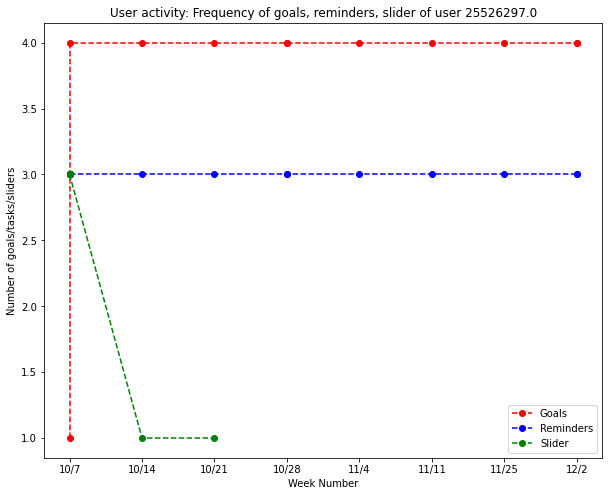

In [555]:
draw_user_activity_date(25526297.0)

### 7.6.2 - Individual usage graph: scatter with dot size

In [556]:
def draw_user_activity_date_with_size(userid):
    df1 = goals_output[goals_output['userId']==userid].groupby(['weekDate',
                                                                  'weekNumber',
                                                                  'goals_num']
                                                                ).count().reset_index().sort_values('weekNumber')
    x1 = df1['weekDate'].values
    y1 = df1['goals_num'].values
    s1 = df1.iloc[:,-1].values
    
    df2 = reminders_output[reminders_output['userId']==userid].groupby(['weekDate',
                                                                  'weekNumber',
                                                                  'tasks_num']
                                                                ).count().reset_index().sort_values('weekNumber')
    x2 = df2['weekDate'].values
    y2 = df2['tasks_num'].values
    s2 = df2.iloc[:,-1].values
    
    df3 = slider_output[slider_output['userId']==userid].groupby(['weekDate',
                                                                  'weekNumber',
                                                                  'sliderFrequency']
                                                                ).count().reset_index().sort_values('weekNumber')
    x3 = df3['weekDate'].values
    y3 = df3['sliderFrequency'].values
    s3 = df3.iloc[:,-1].values
 
    fig, axs = plt.subplots(1,1,figsize=(10,8))
    axs.scatter(x1,y1,s=(s1+2)**4, alpha=0.5,color='green',label='Goals')
    axs.scatter(x2,y2,s=(s2+2)**4, alpha=0.5,color='blue',label='Reminders')
    axs.scatter(x3,y3,s=(s3+2)**4, alpha=0.5,color='red',label='Slider')
    
    axs.legend(markerscale=0.2)
        
    axs.set_title(f'User activity: Frequency of goals, reminders, slider of user {userid}')
    axs.set_xlabel('Week Number')
    axs.set_ylabel('Number of goals/tasks/sliders')

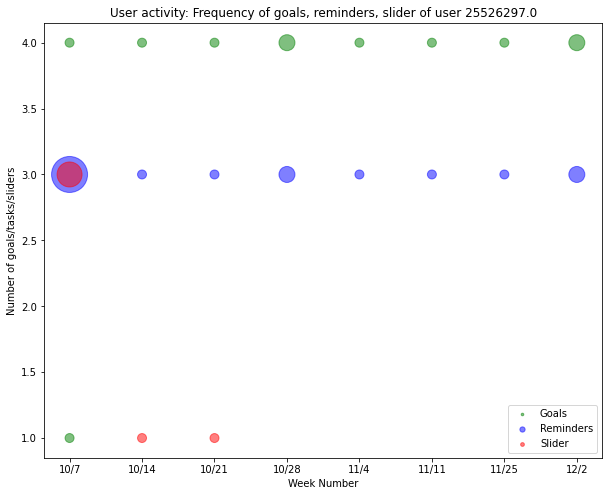

In [557]:
draw_user_activity_date_with_size(25526297.0)
# set the dot size to the number of week-contents
# week-content

### 7.7  `Group graph version 1` :  Group of Learners: by grade

In [558]:
SRLUI_v2 = pd.read_csv('SRLUI_v2_activity_0714/SRLUImaster_v2.csv', index_col=0)

##### Set user group: Course, grade(or other parameter)

In [559]:
# user id set - set how to divide the user group: based on grade? gender? 
high_grade_userid = SRLUI_v2[SRLUI_v2['Grade']>=60]['userId'].values
low_grade_userid  = SRLUI_v2[SRLUI_v2['Grade']< 60]['userId'].values

### - Usage graph by group: scatter with size representing number of learners

In [560]:
def draw_user_activity_group_scatter_size(userid_set, group_name, course_list):
    N = len(SRLUI_v2[(SRLUI_v2['courseId'].isin(course_list))\
                       &(SRLUI_v2['userId'].isin(userid_set))])
    
    # Extract these users' goals_num
    df = goals_output[(goals_output['Course'].isin(course_list))\
                       &(goals_output['userId'].isin(userid_set))][['weekDate','goals_num']]
    df['count'] = 1
    # groupby to check how many learners have set n goals on a/b/ date
    counts = df.groupby(['weekDate','goals_num']).count().reset_index()
    df = df.merge(counts, on = ['weekDate','goals_num']).rename(columns={'count_y':'counts'})
    x1 = df['weekDate'].values
    y1 = df['goals_num'].values
    s1 = df['counts'].values
    
    df = reminders_output[(reminders_output['Course'].isin(course_list))\
                       &(reminders_output['userId'].isin(userid_set))][['weekDate','tasks_num']]
    df['count'] = 1
    counts = df.groupby(['weekDate','tasks_num']).count().reset_index()
    df = df.merge(counts, on = ['weekDate','tasks_num']).rename(columns={'count_y':'counts'})
    x2 = df['weekDate'].values
    y2 = df['tasks_num'].values
    s2 = df['counts'].values
    
    df = slider_output[(slider_output['Course'].isin(course_list))\
                       &(slider_output['userId'].isin(userid_set))][['weekDate','sliderFrequency']]
    df['count'] = 1
    counts = df.groupby(['weekDate','sliderFrequency']).count().reset_index()
    df = df.merge(counts, on = ['weekDate','sliderFrequency']).rename(columns={'count_y':'counts'})
    x3 = df['weekDate'].values
    y3 = df['sliderFrequency'].values
    s3 = df['counts'].values
    
    plt.figure(figsize=(10,8))
    plt.scatter(x1,y1,s=s1**2,label='Goals', alpha=0.5,color='green')
    plt.scatter(x2,y2,s=s2**2,label='Reminders', alpha=0.5,color='red')
    plt.scatter(x3,y3,s=s3**2,label='Slider', alpha=0.5,color='blue')
    plt.legend(loc='best',markerscale=0.2)
    plt.title(f'SRLUI Usage of {group_name}, {N} learners.')
    plt.xlabel('Week Number')
    plt.show()

#### 3 arguments in this function: 
- userid_list (see under **7.7**) 
- a string to name this group, i.e. `"Users with >=60 high grades"`
- a course list, i.e. `['BAMM101','BAMM102','BAMM103','BAMM104']`

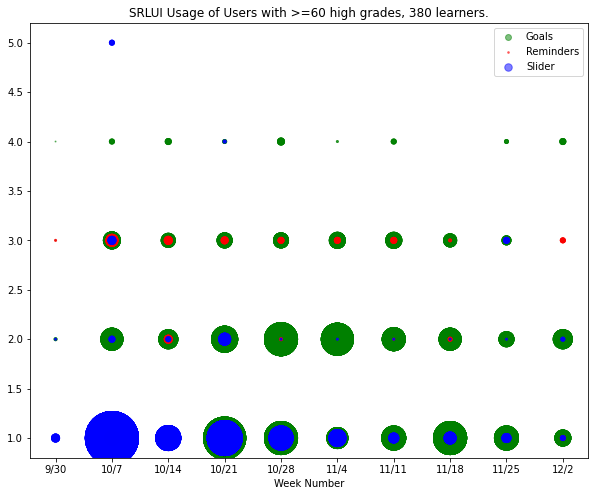

In [561]:
draw_user_activity_group_scatter_size(high_grade_userid, 
                                      'Users with >=60 high grades',
                                     ['BAMM101','BAMM102','BAMM103','BAMM104',
                                     'CSMM101','CSMM102','CsMM103','CSMM104'])

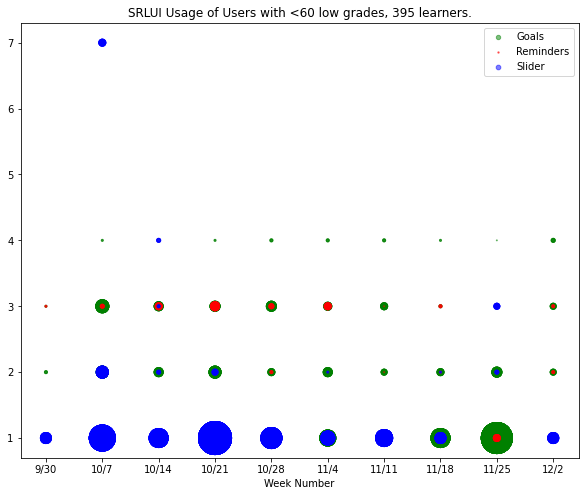

In [562]:
draw_user_activity_group_scatter_size(low_grade_userid, 
                                      'Users with <60 low grades',
                                     ['BAMM101','BAMM102','BAMM103','BAMM104',
                                     'CSMM101','CSMM102','CsMM103','CSMM104'])

### 7.8  `Group graph version 2` :  Group of Learners: by grade

### - Usage graph by group

In [563]:
def draw_user_activity_group_scatter_size(userid_set1, userid_set2, group_name1, group_name2, course_list):
    # number of learners in each group
    N1 = len(SRLUI_v2[(SRLUI_v2['courseId'].isin(course_list))\
                           &(SRLUI_v2['userId'].isin(userid_set1))])
    N2 = len(SRLUI_v2[(SRLUI_v2['courseId'].isin(course_list))\
                           &(SRLUI_v2['userId'].isin(userid_set2))])
    N = len(SRLUI_v2[SRLUI_v2['courseId'].isin(course_list)])
    
    # Extract goals_frequncy - N1
    df = goals_output[(goals_output['Course'].isin(course_list))\
                       &(goals_output['userId'].isin(userid_set1))][['weekDate','goals_num']]
    df = df.groupby(['weekDate']).count().reset_index()
    x11 = df['weekDate'].values
    y11 = [group_name1 for i in range(len(x11))]
    s11 = df.iloc[:,-1].values
    # Extract goals_frequncy - N2
    df = goals_output[(goals_output['Course'].isin(course_list))\
                       &(goals_output['userId'].isin(userid_set2))][['weekDate','goals_num']]
    df = df.groupby(['weekDate']).count().reset_index()
    x12 = df['weekDate'].values
    y12 = [group_name2 for i in range(len(x12))]
    s12 = df.iloc[:,-1].values
    
    
    # Extract reminders_frequncy - N1
    df = reminders_output[(reminders_output['Course'].isin(course_list))\
                       &(reminders_output['userId'].isin(userid_set1))][['weekDate','tasks_num']]
    df = df.groupby(['weekDate']).count().reset_index()
    x21 = df['weekDate'].values
    y21 = [group_name1 for i in range(len(x21))]
    s21 = df.iloc[:,-1].values
    # Extract reminders_frequncy - N2
    df = reminders_output[(reminders_output['Course'].isin(course_list))\
                       &(reminders_output['userId'].isin(userid_set2))][['weekDate','tasks_num']]
    df = df.groupby(['weekDate']).count().reset_index()
    x22 = df['weekDate'].values
    y22 = [group_name2 for i in range(len(x22))]
    s22 = df.iloc[:,-1].values
    
    
    # Extract slider_frequncy - N1
    df = slider_output[(slider_output['Course'].isin(course_list))\
                       &(slider_output['userId'].isin(userid_set1))][['weekDate','sliderFrequency']]
    df = df.groupby(['weekDate']).count().reset_index()
    x31 = df['weekDate'].values
    y31 = [group_name1 for i in range(len(x31))]
    s31 = df.iloc[:,-1].values
    # Extract slider_frequncy - N2
    df = slider_output[(slider_output['Course'].isin(course_list))\
                       &(slider_output['userId'].isin(userid_set2))][['weekDate','sliderFrequency']]
    df = df.groupby(['weekDate']).count().reset_index()
    x32 = df['weekDate'].values
    y32 = [group_name2 for i in range(len(x32))]
    s32 = df.iloc[:,-1].values
    
    
    fig, axs = plt.subplots(3,1,figsize=(15,12),constrained_layout=True)
    fig.suptitle(f'SRLUI Usage of {group_name1} & {group_name2}, {N} learners.',fontsize=16)
    axs[0].scatter(x11,y11,s=s11**2,label=f'{group_name1}: {N1} learners', alpha=0.7,color='#1FBB85')
    axs[0].scatter(x12,y12,s=s12**2,label=f'{group_name2}: {N2} learners', alpha=0.4,color='#1FBB85')
    axs[0].set_title(f'Goals Activity',fontsize=16)
    axs[0].set_ylim(-1,2.5)
    axs[0].legend(loc='best',markerscale=0.1)
    axs[1].scatter(x21,y21,s=s21**2,label=f'{group_name1}: {N1} learners', alpha=0.7,color='red')
    axs[1].scatter(x22,y22,s=s22**2,label=f'{group_name2}: {N2} learners',  alpha=0.4,color='red')
    axs[1].set_title(f'Reminders Activity',fontsize=16)
    axs[1].set_ylim(-1,2.5)
    axs[1].legend(loc='best',markerscale=0.1)
    axs[2].scatter(x31,y31,s=s31**2,label=f'{group_name1}: {N1} learners', alpha=0.7,color='blue')
    axs[2].scatter(x32,y32,s=s32**2,label=f'{group_name2}: {N2} learners',  alpha=0.4,color='blue')
    axs[2].set_title(f'Slider Activity',fontsize=16)
    axs[2].set_ylim(-1,2.5)
    axs[2].legend(loc='best',markerscale=0.1)
    
    plt.xlabel('Week Number',fontsize=14)
    plt.show()

#### 5 arguments in this function: 
1. `userid_set1`: i.e.   high_grade_userid
2. `userid_set2`: i.e.   low_grade_userid
3. `group_name1`: a string to name group1, i.e. `"High grade"`
4. `group_name2`: a string to name group2, i.e. `"Low grade"`
5. `course list`, i.e. `['BAMM101','BAMM102','BAMM103','BAMM104']`

##### PLOT1:  HIGH & LOW Grade groups

In [564]:
# user id set - set how to divide the user group: based on grade? gender? 
high_grade_userid = SRLUI_v2[SRLUI_v2['Grade']>=60]['userId'].values
low_grade_userid  = SRLUI_v2[SRLUI_v2['Grade']< 60]['userId'].values

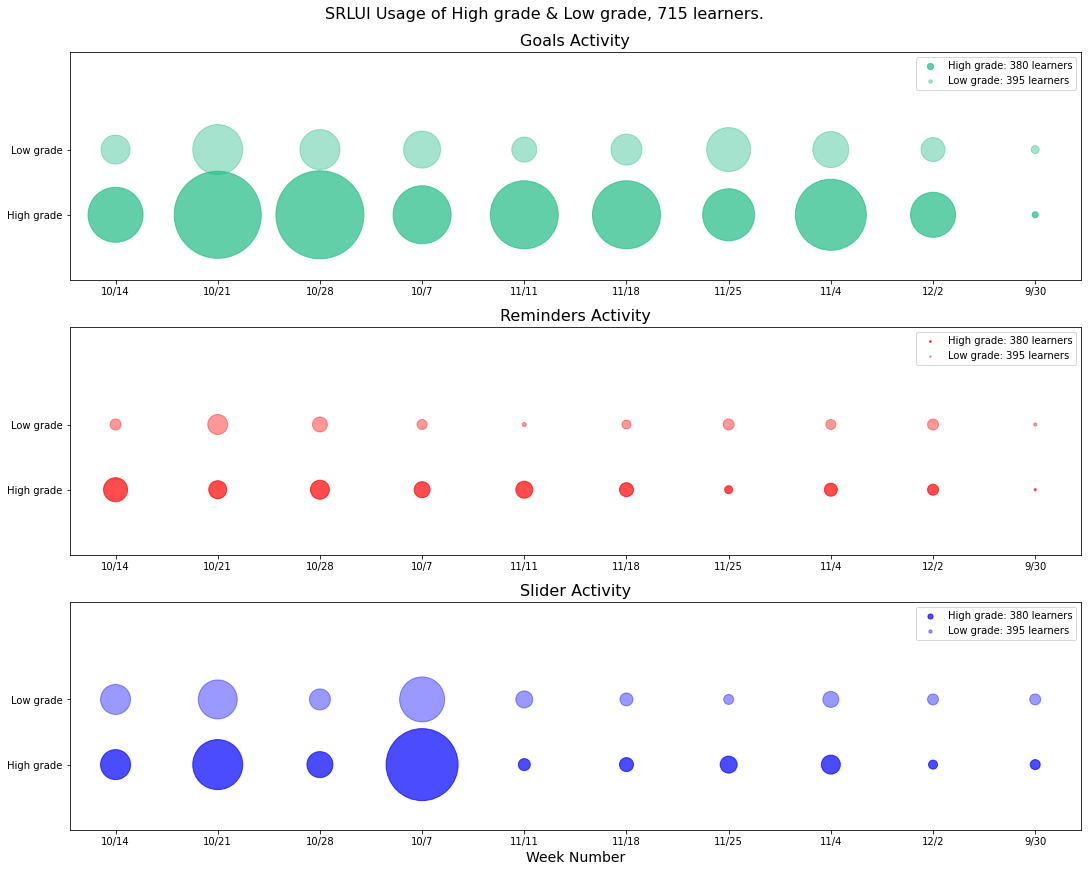

In [565]:
draw_user_activity_group_scatter_size(
    high_grade_userid, 
    low_grade_userid,
    'High grade', 
    'Low grade',
    ['BAMM101','BAMM102','BAMM103','BAMM104','CSMM101','CSMM102','CsMM103','CSMM104'])

##### PLOT2:  DROPOUT & NON-DROPOUT  groups

In [566]:
non_dropout_userid = SRLUI_v2[SRLUI_v2['drop_out']==0]['userId'].values
dropout_userid  = SRLUI_v2[SRLUI_v2['drop_out']==1]['userId'].values

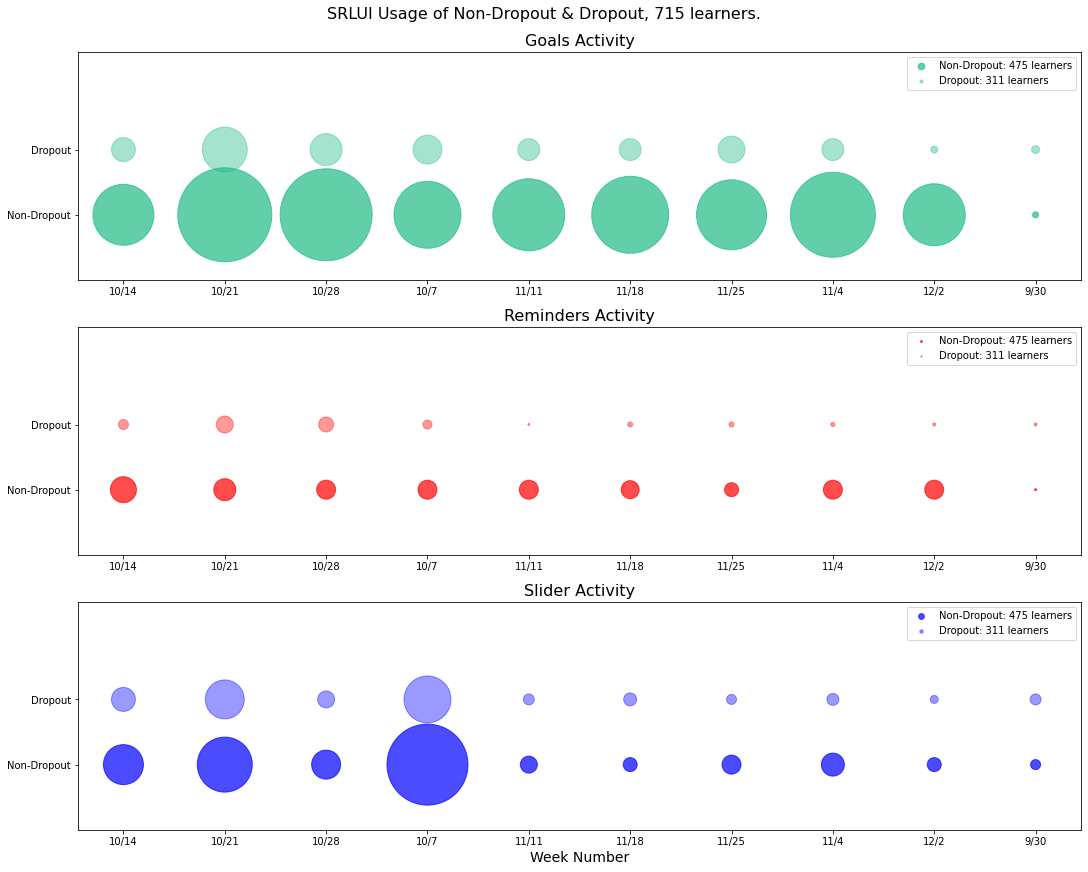

In [567]:
draw_user_activity_group_scatter_size(
    non_dropout_userid, 
    dropout_userid,
    'Non-Dropout', 
    'Dropout',
    ['BAMM101','BAMM102','BAMM103','BAMM104','CSMM101','CSMM102','CsMM103','CSMM104'])

##### PLOT3:  experiment & control  groups

In [568]:
experiment_userid = SRLUI_v2[SRLUI_v2['treatment']=='experiment']['userId'].values
control_userid  = SRLUI_v2[SRLUI_v2['treatment']=='control']['userId'].values

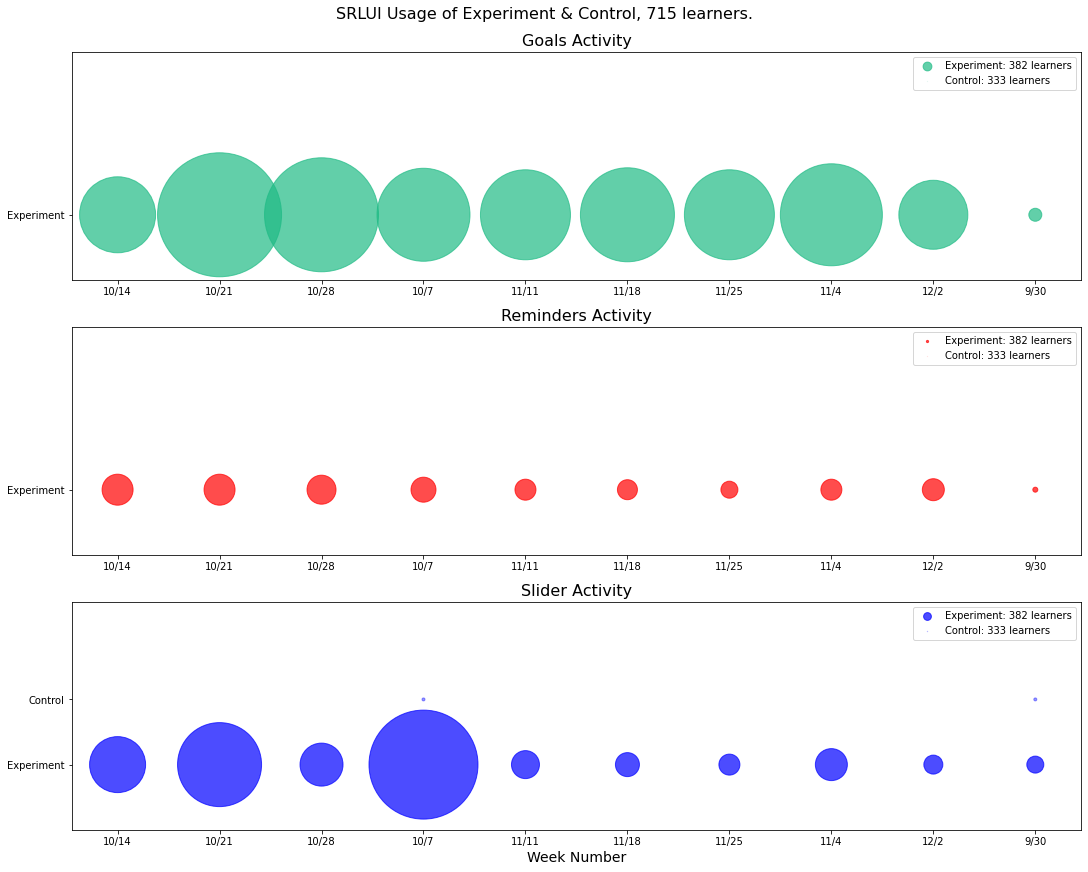

In [569]:
draw_user_activity_group_scatter_size(
    experiment_userid, 
    control_userid,
    'Experiment', 
    'Control',
    ['BAMM101','BAMM102','BAMM103','BAMM104','CSMM101','CSMM102','CsMM103','CSMM104'])

## Appendix

### - Usage graph by group: simple scatter

### 7.8 Difference of usage patterns among groups

- plot the frequency plot?
    - i.e. Goals
    - x: 1,2,3,4
    - y: frequency
- test whether the means come from the same population?

##### Set user group: Course, grade(or other parameter)